In [1]:
import sys, os, importlib, numpy as np, pandas as pd
sys.path.append(os.path.abspath(".."))

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from src import data as data_mod, features as features_mod, utils as utils_mod
importlib.reload(data_mod); importlib.reload(features_mod); importlib.reload(utils_mod)
from src.data import get_data
from src.features import add_features
from src.utils import make_labels

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [2]:
# Dead-zone labels to reduce noise: ±0.1%
df = get_data("AAPL", start="2015-01-01", end="2023-12-31")
df = add_features(df)
df = make_labels(df, tau=0.001, dead_zone=True)

drop_cols = ["date","open","high","low","close","volume","ret_next","y"]
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].values.astype(np.float32)
y = df["y"].astype(np.float32).values
dates = df["date"].values

len(df), len(feat_cols), feat_cols[:10]


(2078,
 8,
 ['ret1', 'ret5', 'ret10', 'vol10', 'volz', 'rsi14', 'macd', 'macd_signal'])

In [3]:
n = len(df)
i_tr, i_va = int(0.70*n), int(0.85*n)

X_tr, y_tr = X[:i_tr], y[:i_tr]
X_va, y_va = X[i_tr:i_va], y[i_tr:i_va]
X_te, y_te = X[i_va:], y[i_va:]

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr).astype(np.float32)
X_va = scaler.transform(X_va).astype(np.float32)
X_te = scaler.transform(X_te).astype(np.float32)

X_tr.shape, X_va.shape, X_te.shape


((1454, 8), (312, 8), (312, 8))

In [4]:
class SeqDataset(Dataset):
    def __init__(self, X, y, window=30):
        self.X = X
        self.y = y
        self.window = window

        # build index of valid sequence ends
        self.ends = np.arange(window, len(X))

    def __len__(self):
        return len(self.ends)

    def __getitem__(self, idx):
        end = self.ends[idx]
        start = end - self.window
        x_seq = self.X[start:end]
        y_t = self.y[end]
        return torch.from_numpy(x_seq), torch.tensor(y_t, dtype=torch.float32)

def make_loaders(X_tr, y_tr, X_va, y_va, X_te, y_te, window=30, batch=128):
    ds_tr = SeqDataset(X_tr, y_tr, window)
    ds_va = SeqDataset(X_va, y_va, window)
    ds_te = SeqDataset(X_te, y_te, window)

    dl_tr = DataLoader(ds_tr, batch_size=batch, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch, shuffle=False, drop_last=False)
    dl_te = DataLoader(ds_te, batch_size=batch, shuffle=False, drop_last=False)
    return ds_tr, ds_va, ds_te, dl_tr, dl_va, dl_te

window = 30
ds_tr, ds_va, ds_te, dl_tr, dl_va, dl_te = make_loaders(X_tr, y_tr, X_va, y_va, X_te, y_te, window=window, batch=128)
len(ds_tr), len(ds_va), len(ds_te)


(1424, 282, 282)

In [5]:
class LSTMClf(nn.Module):
    def __init__(self, in_dim, hidden=64, layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x):         # x: [B, T, F]
        out, _ = self.lstm(x)
        out = out[:, -1, :]       # last time step
        p = self.head(out).squeeze(-1)
        return p

model = LSTMClf(in_dim=len(feat_cols), hidden=96, layers=1, dropout=0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
bce = nn.BCELoss()
model


LSTMClf(
  (lstm): LSTM(8, 96, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=96, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [6]:
def train_epoch(model, dl):
    model.train()
    total, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        p = model(xb)
        loss = bce(p, yb)
        loss.backward()
        opt.step()
        total += loss.item() * len(yb)
        n += len(yb)
    return total / max(n,1)

@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    Ps, Ys = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        p = model(xb).detach().cpu().numpy()
        Ps.append(p)
        Ys.append(yb.numpy())
    P = np.concatenate(Ps)
    Y = np.concatenate(Ys)
    pred = (P > 0.5).astype(int)
    metrics = {
        "AUC": float(roc_auc_score(Y, P)) if len(np.unique(Y)) > 1 else float("nan"),
        "BalAcc": float(balanced_accuracy_score(Y, pred)),
        "F1": float(f1_score(Y, pred))
    }
    return metrics, P, Y


In [7]:
best_va_auc = -1
best_state = None
epochs = 15

for ep in range(1, epochs+1):
    tr_loss = train_epoch(model, dl_tr)
    va_metrics, P_va, Y_va = evaluate(model, dl_va)
    if va_metrics["AUC"] > best_va_auc:
        best_va_auc = va_metrics["AUC"]
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
    print(f"epoch {ep:02d} | loss {tr_loss:.4f} | val AUC {va_metrics['AUC']:.3f} "
          f"| BalAcc {va_metrics['BalAcc']:.3f} | F1 {va_metrics['F1']:.3f}")

# load best
if best_state is not None:
    model.load_state_dict(best_state)


epoch 01 | loss 0.6942 | val AUC 0.555 | BalAcc 0.544 | F1 0.646
epoch 02 | loss 0.6905 | val AUC 0.475 | BalAcc 0.474 | F1 0.629
epoch 03 | loss 0.6904 | val AUC 0.467 | BalAcc 0.465 | F1 0.612
epoch 04 | loss 0.6896 | val AUC 0.486 | BalAcc 0.475 | F1 0.640
epoch 05 | loss 0.6887 | val AUC 0.507 | BalAcc 0.495 | F1 0.678
epoch 06 | loss 0.6886 | val AUC 0.504 | BalAcc 0.499 | F1 0.662
epoch 07 | loss 0.6885 | val AUC 0.572 | BalAcc 0.525 | F1 0.691
epoch 08 | loss 0.6876 | val AUC 0.571 | BalAcc 0.532 | F1 0.697
epoch 09 | loss 0.6869 | val AUC 0.534 | BalAcc 0.497 | F1 0.653
epoch 10 | loss 0.6863 | val AUC 0.573 | BalAcc 0.524 | F1 0.680
epoch 11 | loss 0.6848 | val AUC 0.575 | BalAcc 0.508 | F1 0.676
epoch 12 | loss 0.6842 | val AUC 0.548 | BalAcc 0.500 | F1 0.640
epoch 13 | loss 0.6841 | val AUC 0.556 | BalAcc 0.510 | F1 0.651
epoch 14 | loss 0.6854 | val AUC 0.551 | BalAcc 0.489 | F1 0.635
epoch 15 | loss 0.6835 | val AUC 0.566 | BalAcc 0.515 | F1 0.667


In [8]:
va_metrics, P_va, Y_va = evaluate(model, dl_va)
te_metrics, P_te, Y_te = evaluate(model, dl_te)

print("Validation:", va_metrics)
print("Test      :", te_metrics)

print("\nTest Confusion Matrix @0.5:")
print(confusion_matrix(Y_te, (P_te>0.5).astype(int)))
print(classification_report(Y_te, (P_te>0.5).astype(int), digits=3))


Validation: {'AUC': 0.5749608921632942, 'BalAcc': 0.5082000302770349, 'F1': 0.6764705882352942}
Test      : {'AUC': 0.5487012987012987, 'BalAcc': 0.5078632305194806, 'F1': 0.6997635933806147}

Test Confusion Matrix @0.5:
[[  7 121]
 [  6 148]]
              precision    recall  f1-score   support

         0.0      0.538     0.055     0.099       128
         1.0      0.550     0.961     0.700       154

    accuracy                          0.550       282
   macro avg      0.544     0.508     0.400       282
weighted avg      0.545     0.550     0.427       282



In [9]:
def strat_sharpe_from_probs(p, y_next, fee=0.0010, thr=0.55):
    pos = (p > thr).astype(int)
    trades = np.abs(np.diff(np.r_[0, pos])) * fee
    strat_r = pos * y_next - trades
    s = strat_r.std()
    return 0.0 if s == 0 else strat_r.mean()/s*np.sqrt(252)

# Build aligned VAL/TEST ret_next arrays for the sequence datasets
# For a window of W, ds_va[i] predicts y at index i+W; we align returns accordingly:
val_slice = slice(int(0.70*len(df)), int(0.85*len(df)))
test_slice = slice(int(0.85*len(df)), len(df))

val_ret_next = df.iloc[val_slice]["ret_next"].values[window:]   # drop first 'window' to align P_va
test_ret_next = df.iloc[test_slice]["ret_next"].values[window:] # align with P_te

grid = np.linspace(0.50, 0.60, 21)
scores = [(t, strat_sharpe_from_probs(P_va, val_ret_next, fee=0.0010, thr=t)) for t in grid]
thr = max(scores, key=lambda x: x[1])[0]
thr


np.float64(0.525)

LSTM Strategy Sharpe: 1.1208711694840694
Buy&Hold Sharpe    : 1.286398699851496
LSTM MaxDD: -0.23281303547099352 | BH MaxDD: -0.19549471760204606


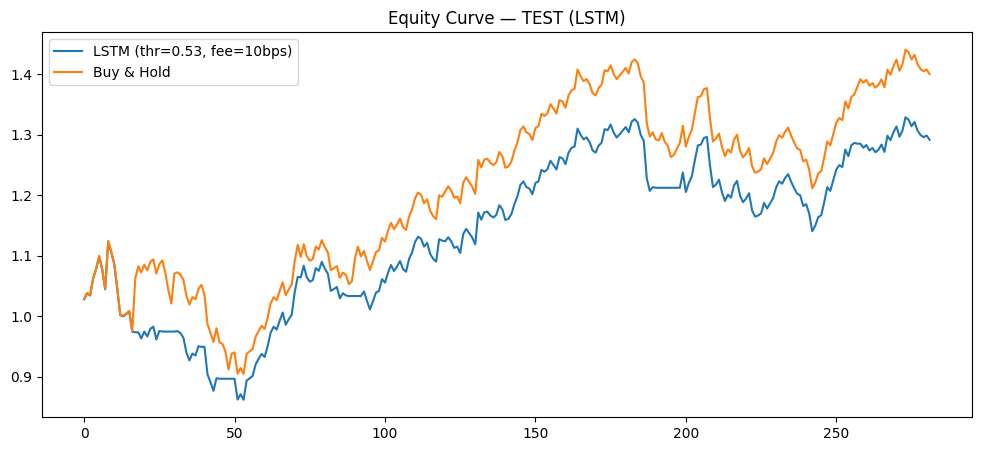

In [10]:
fee = 0.0010
pos = (P_te > thr).astype(int)
trades = np.abs(np.diff(np.r_[0, pos])); costs = trades * fee
strat_r = pos * test_ret_next - costs
bh_r    = test_ret_next

def equity_curve(returns): return (1 + pd.Series(returns)).cumprod()
def sharpe(r): s=np.std(r); return 0 if s==0 else np.mean(r)/s*np.sqrt(252)
def max_drawdown(eq): peak=eq.cummax(); return (eq/peak - 1).min()

eq_s, eq_b = equity_curve(strat_r), equity_curve(bh_r)
print("LSTM Strategy Sharpe:", sharpe(strat_r))
print("Buy&Hold Sharpe    :", sharpe(bh_r))
print("LSTM MaxDD:", max_drawdown(eq_s), "| BH MaxDD:", max_drawdown(eq_b))

plt.figure(figsize=(12,5))
plt.plot(eq_s.values, label=f"LSTM (thr={thr:.2f}, fee=10bps)")
plt.plot(eq_b.values, label="Buy & Hold")
plt.title("Equity Curve — TEST (LSTM)")
plt.legend(); plt.show()


In [11]:
# Save only test-slice predictions aligned with dates (skip first 'window' rows)
test_dates = df.iloc[int(0.85*len(df)):]["date"].values[window:]
out = pd.DataFrame({
    "date": test_dates,
    "p_lstm": P_te,          # LSTM test probabilities
    "ret_next": test_ret_next
})
out.to_csv("../data/aapl_lstm_test_preds.csv", index=False)
"Saved to data/aapl_lstm_test_preds.csv"


'Saved to data/aapl_lstm_test_preds.csv'

In [12]:
# Sanity check: coverage & trades on TEST
coverage = (P_te > thr).mean()
trades = int(np.abs(np.diff(np.r_[0, (P_te > thr).astype(int)])).sum())
print(f"Coverage (days in position): {coverage:.2%}")
print(f"Trades: {trades}")


Coverage (days in position): 88.30%
Trades: 19


In [13]:
import torch.nn as nn

class GRUClf(nn.Module):
    def __init__(self, in_dim, hidden=96, layers=1, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.head = nn.Sequential(nn.Linear(hidden, 1), nn.Sigmoid())

    def forward(self, x):         # x: [B, T, F]
        out, _ = self.gru(x)
        out = out[:, -1, :]       # last time step
        return self.head(out).squeeze(-1)


In [14]:
gru = GRUClf(in_dim=len(feat_cols), hidden=96, layers=1, dropout=0.2).to(device)
opt = torch.optim.Adam(gru.parameters(), lr=1e-3)
bce = nn.BCELoss()

best_va_auc_gru, best_state_gru = -1, None
epochs = 15

for ep in range(1, epochs+1):
    tr_loss = train_epoch(gru, dl_tr)
    va_metrics, P_va_gru, Y_va_gru = evaluate(gru, dl_va)
    if va_metrics["AUC"] > best_va_auc_gru:
        best_va_auc_gru = va_metrics["AUC"]
        best_state_gru = {k: v.cpu().clone() for k, v in gru.state_dict().items()}
    print(f"[GRU] epoch {ep:02d} | loss {tr_loss:.4f} | val AUC {va_metrics['AUC']:.3f} "
          f"| BalAcc {va_metrics['BalAcc']:.3f} | F1 {va_metrics['F1']:.3f}")

if best_state_gru is not None:
    gru.load_state_dict(best_state_gru)

# final metrics
va_metrics_gru, P_va_gru, Y_va_gru = evaluate(gru, dl_va)
te_metrics_gru, P_te_gru, Y_te_gru = evaluate(gru, dl_te)
print("Validation (GRU):", va_metrics_gru)
print("Test (GRU):", te_metrics_gru)


[GRU] epoch 01 | loss 0.6920 | val AUC 0.498 | BalAcc 0.486 | F1 0.648
[GRU] epoch 02 | loss 0.6904 | val AUC 0.533 | BalAcc 0.512 | F1 0.680
[GRU] epoch 03 | loss 0.6895 | val AUC 0.488 | BalAcc 0.489 | F1 0.633
[GRU] epoch 04 | loss 0.6891 | val AUC 0.540 | BalAcc 0.507 | F1 0.680
[GRU] epoch 05 | loss 0.6889 | val AUC 0.524 | BalAcc 0.493 | F1 0.651
[GRU] epoch 06 | loss 0.6889 | val AUC 0.518 | BalAcc 0.510 | F1 0.632
[GRU] epoch 07 | loss 0.6887 | val AUC 0.532 | BalAcc 0.525 | F1 0.618
[GRU] epoch 08 | loss 0.6885 | val AUC 0.531 | BalAcc 0.498 | F1 0.649
[GRU] epoch 09 | loss 0.6876 | val AUC 0.501 | BalAcc 0.499 | F1 0.646
[GRU] epoch 10 | loss 0.6872 | val AUC 0.526 | BalAcc 0.499 | F1 0.665
[GRU] epoch 11 | loss 0.6869 | val AUC 0.564 | BalAcc 0.518 | F1 0.686
[GRU] epoch 12 | loss 0.6861 | val AUC 0.513 | BalAcc 0.503 | F1 0.626
[GRU] epoch 13 | loss 0.6864 | val AUC 0.518 | BalAcc 0.504 | F1 0.620
[GRU] epoch 14 | loss 0.6848 | val AUC 0.578 | BalAcc 0.524 | F1 0.661
[GRU] 

In [15]:
# Uses your existing funcs: strat_sharpe_from_probs, equity_curve/sharpe/max_drawdown (defined earlier)

# Align returns (same as LSTM): drop first `window` to match sequence outputs
val_slice  = slice(int(0.70*len(df)), int(0.85*len(df)))
test_slice = slice(int(0.85*len(df)), len(df))
val_ret_next  = df.iloc[val_slice]["ret_next"].values[window:]
test_ret_next = df.iloc[test_slice]["ret_next"].values[window:]

grid = np.linspace(0.50, 0.60, 21)
thr_gru = max(grid, key=lambda t: strat_sharpe_from_probs(P_va_gru, val_ret_next, fee=0.0010, thr=t))
thr_gru


np.float64(0.54)

GRU Strategy Sharpe: 1.2691037565655112
Buy&Hold Sharpe    : 1.286398699851496
GRU MaxDD: -0.20849547141702618 | BH MaxDD: -0.19549471760204606


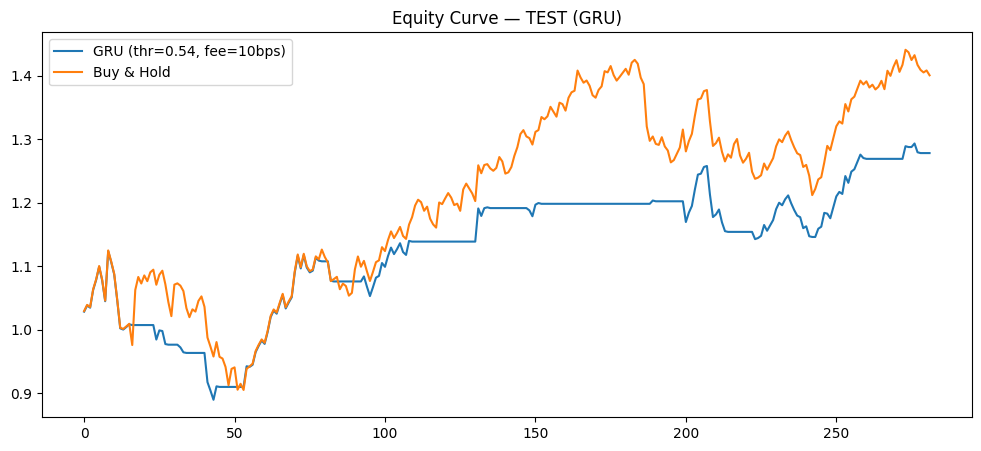

In [16]:
fee = 0.0010
pos = (P_te_gru > thr_gru).astype(int)
trades = np.abs(np.diff(np.r_[0, pos])); costs = trades * fee
strat_r = pos * test_ret_next - costs
bh_r    = test_ret_next

def equity_curve(returns): return (1 + pd.Series(returns)).cumprod()
def sharpe(r): s=np.std(r); return 0 if s==0 else np.mean(r)/s*np.sqrt(252)
def max_drawdown(eq): peak=eq.cummax(); return (eq/peak - 1).min()

eq_s, eq_b = equity_curve(strat_r), equity_curve(bh_r)
print("GRU Strategy Sharpe:", sharpe(strat_r))
print("Buy&Hold Sharpe    :", sharpe(bh_r))
print("GRU MaxDD:", max_drawdown(eq_s), "| BH MaxDD:", max_drawdown(eq_b))

plt.figure(figsize=(12,5))
plt.plot(eq_s.values, label=f"GRU (thr={thr_gru:.2f}, fee=10bps)")
plt.plot(eq_b.values, label="Buy & Hold")
plt.title("Equity Curve — TEST (GRU)")
plt.legend(); plt.show()


Coverage (days in position): 44.68%
Trades: 36


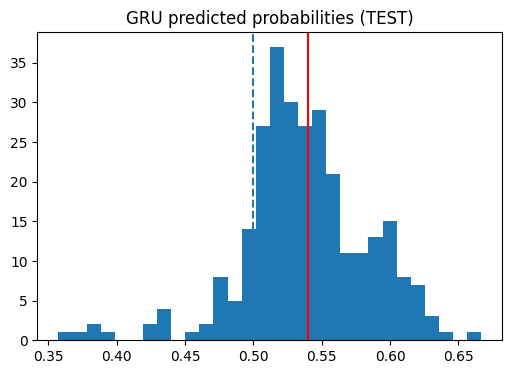

In [17]:
coverage = (P_te_gru > thr_gru).mean()
trades = int(np.abs(np.diff(np.r_[0,(P_te_gru>thr_gru).astype(int)])).sum())
print(f"Coverage (days in position): {coverage:.2%}")
print(f"Trades: {trades}")

plt.figure(figsize=(6,4))
plt.hist(P_te_gru, bins=30)
plt.axvline(0.5, ls="--"); plt.axvline(thr_gru, color="r")
plt.title("GRU predicted probabilities (TEST)")
plt.show()


In [18]:
configs = [
    ("LSTM", 64, 1, 0.2),
    ("LSTM", 128, 1, 0.2),
    ("GRU",  64, 1, 0.2),
    ("GRU",  128, 1, 0.2),
]
def run_config(kind, hidden, layers, dropout):
    if kind=="LSTM":
        m = LSTMClf(in_dim=len(feat_cols), hidden=hidden, layers=layers, dropout=dropout).to(device)
    else:
        m = GRUClf(in_dim=len(feat_cols), hidden=hidden, layers=layers, dropout=dropout).to(device)
    opt = torch.optim.Adam(m.parameters(), lr=1e-3)
    best = -1
    for _ in range(8):
        _ = train_epoch(m, dl_tr)
        metrics, _, _ = evaluate(m, dl_va)
        best = max(best, metrics["AUC"])
    return best

rows = []
for kind, hidden, layers, dropout in configs:
    auc = run_config(kind, hidden, layers, dropout)
    rows.append({"model": kind, "hidden": hidden, "layers": layers, "dropout": dropout, "val_auc_best": round(auc,4)})
pd.DataFrame(rows)


,model,hidden,layers,dropout,val_auc_best
0,LSTM,64,1,0.2,0.5309
1,LSTM,128,1,0.2,0.5744
2,GRU,64,1,0.2,0.4506
3,GRU,128,1,0.2,0.4276
